In [2]:
import numpy as np
import pandas as pd
import pylab as pl
from sklearn.ensemble.forest import RandomForestRegressor
from scipy.sparse import csc_matrix
import xgboost as xgb
import seaborn as sns
import gc

%matplotlib inline
pd.set_option('display.mpl_style', 'default')
pl.rcParams['figure.figsize'] = (20.0, 10.0)
pl.rcParams['mathtext.fontset'] = 'cm'

def load_data(filename_train, filename_test, filename_store, filename_clusters, print_missing=False):

    train = pd.read_csv(filename_train, header=0, low_memory=False)
    test = pd.read_csv(filename_test, header=0, low_memory=False)
    store_info = pd.read_csv(filename_store, header=0, low_memory=False)
    store_clusters = pd.read_csv(filename_clusters, header=0, low_memory=False)

    train.Date = pd.to_datetime(train.Date)
    test.Date = pd.to_datetime(test.Date)
    
    test.Open = test.Open.fillna(1)
    train = train[train.Open == 1]

    store_info.CompetitionDistance = store_info.CompetitionDistance.fillna(0)
    store_info.CompetitionOpenSinceMonth = store_info.CompetitionOpenSinceMonth.fillna(0).astype(int)
    store_info.CompetitionOpenSinceYear = store_info.CompetitionOpenSinceYear.fillna(0).astype(int)
    store_info.Promo2SinceWeek = store_info.Promo2SinceWeek.fillna(0).astype(int)
    store_info.Promo2SinceYear = store_info.Promo2SinceYear.fillna(0).astype(int)

    promo_intervals = [np.NaN] + list(store_info.PromoInterval.value_counts().index)
    store_info.PromoInterval = store_info.PromoInterval.map(lambda x: promo_intervals.index(x))
    
    store_info = pd.merge(store_info, store_clusters, how='left', on='Store')
    
    return train, test, store_info

train, test, store_info = load_data('train.csv', 'test.csv', 'store.csv', 'store_clusters.csv')

In [3]:
def merge_with_store(data, store_info):    
    columns = store_info.columns
    data = pd.merge(data, store_info[columns], on='Store', how='left')
    return data

def construct_some_features(data):
    data['Day'] = data.Date.map(lambda d: d.day).astype(int)
    data['Month'] = data.Date.map(lambda d: d.month).astype(int)
    data['Week'] = data.Date.map(lambda d: d.week % 4).astype(int)
    data['DayOfYear'] = data.Date.map(lambda d: d.dayofyear).astype(int)
    data['Year'] = data.Date.map(lambda d: d.year)
    
    data['DiffToday'] = ((pd.datetime(2015, 9, 18) - data.Date)
                                     / np.timedelta64(1, 'D')).astype(int)
    data['DiffNewYear'] = data.Date.map(lambda d: (min(d - pd.datetime(d.year, 1, 1),
                                  pd.datetime(d.year + 1, 12, 31) - d) / np.timedelta64(1, 'D')).astype(int))
    data['DiffFoolDay'] = data.Date.map(lambda d: ((d - pd.datetime(d.year, 4, 1))
                                                                           / np.timedelta64(1, 'D')).astype(int))
    
    data['DiffCompetitionYear'] = data['Year'] - data['CompetitionOpenSinceYear']
    data.ix[data.CompetitionOpenSinceYear == 0, 'DiffCompetitionYear'] = 0
    
    data['DayMonthChange'] = data.Day.map(lambda x: 28 <= x <= 31 or 1 <= x <= 4).astype('int8')
    data['DayMonthAfterMiddle'] = data.Day.map(lambda x: 19 <= x <= 26).astype('int8')
    
    data = pd.get_dummies(data, columns=['StateHoliday', 'Month', 'StoreType', 'Assortment',
                                         'DayOfWeek', 'Year', 'PromoInterval', 'Week', 'Cluster'], sparse=True) 
    return data

data = train.append(test)
data = merge_with_store(data, store_info)
data = construct_some_features(data)
train = data[:len(train)]
test = data[len(train):]
del data, test['Sales'], test['Customers'], train['Id'], train['Customers'], train['Open'], store_info
print('Memory usage of dataframe train is %3.2f Mb' % (train.memory_usage(index=True).sum()/(1024*1024)))
print('Memory usage of dataframe test is %3.2f Mb' % (test.memory_usage(index=True).sum()/(1024*1024)))
print(len(test.columns) - 2, 'features')
gc.collect()

Memory usage of dataframe train is 220.65 Mb
Memory usage of dataframe test is 11.05 Mb
116 features


161

In [4]:
def get_dates_CV(k):
    if k >= 16:
        k = 15
        print('maximum number of cross-validation folds is 15')
    date_range = pd.date_range('2013-01-01', '2015-07-31')
    for i in range(k):
        temp_date_range = date_range.shift(-i*48)[48*i:]
        train_date_range = temp_date_range[:-48]
        test_date_range = temp_date_range[-48:] 
        yield train_date_range, test_date_range

In [5]:
def get_data_CV(train_data, number_of_folds=1, feature_selection=None, print_verbose=False, algorithm='xgb'):
    for i, date_ranges in enumerate(get_dates_CV(number_of_folds)):
        date_range_train, date_range_test = date_ranges
        if print_verbose:
            print('Fold #%d' % (i+1))
            print('     Train -> ', [str(date_ranges[0][0]), str(date_ranges[0][-1])])
            print('Validation -> ', [str(date_ranges[1][0]), str(date_ranges[1][-1])])
        
        train_fold = train_data[train_data.Date.isin(date_range_train)]
        test_fold = train_data[train_data.Date.isin(date_range_test)]
        train_fold_labels = np.array(train_fold.Sales)
        test_fold_labels = np.array(test_fold.Sales)
        del train_fold['Date'], test_fold['Date'], train_fold['Sales'], test_fold['Sales']
        
        if feature_selection:
            train_fold = train_fold[feature_selection]
            test_fold = test_fold[feature_selection]
        yield csc_matrix(train_fold), train_fold_labels, csc_matrix(test_fold), \
            test_fold_labels, train_fold.columns

def get_all_data(train_data, test_data, feature_selection=None, print_verbose=False, algorithm='rf'):
    print('Train -> all dates')
    print(' Test -> need to predict')
    train_array_labels = np.array(train_data.Sales)
    train_array = train_data[[x for x in train_data.columns if x not in ['Sales', 'Date']]] 
    test_array = test_data[[x for x in test_data.columns if x not in ['Date', 'Id', 'Open']]]
    
    if feature_selection:
        train_array = train_array[feature_selection]
        test_array = test_array[feature_selection]
    
    return csc_matrix(train_array), train_array_labels, csc_matrix(test_array), train_array.columns

### Predicting

In [6]:
def compute_RMSPE(test_labels, predicted_labels):
    mask = test_labels.nonzero()
    y = test_labels[mask]
    y_hat = predicted_labels[mask]
    return np.sqrt(np.mean(((y - y_hat)/y)**2))

In [12]:
def fit_predict_model(train_array, train_array_labels, test_array, feature_names, algorithm='xgb', alpha=None,
                      plot_importances=True):
    if algorithm == 'xgb':
        clf = xgb.XGBRegressor(n_estimators=810, learning_rate=0.05, max_depth=13,
                               colsample_bytree=0.7, subsample=0.9)
        clf.fit(train_array, train_array_labels)
        if plot_importances:
            with open('xgb.fmap', 'w') as outfile:
                for i, feature_name in enumerate(feature_names):
                    outfile.write('{0}\t{1}\tq\n'.format(i, feature_name))
            importances = clf.booster().get_fscore('xgb.fmap')
            feature_names = list(importances.keys())
            importances = np.array(list(importances.values()))
            pl.title('Feature Importance')
            sorted_indices = np.argsort(importances)[::-1]
            for i, k in enumerate(sorted_indices):
                print('%2d (feature %2d):' % (i, k), feature_names[k], 'Value = %.5f' % importances[k])
            print([feature_names[k] for k in sorted_indices])
            sns.barplot(np.arange(len(feature_names)), importances[sorted_indices], color='r')
            
        test_predicted_labels = clf.predict(test_array)
    else:
        assert False
    return test_predicted_labels

In [8]:
def train_and_score(train_data, number_of_folds, grid_space=[0], feature_selection=None,
                    algorithm='xgb', plot_importances=True):
    """ to compute min alpha len(grid_space) must be > 1 """
    print(str(algorithm).upper(), 'is working...')
    if len(grid_space) <= 1:
        print_verbose_data = True
    else:
        print_verbose_data = False
        alphas, scores = [], []
        min_alpha, min_score = 1., 10**5
        
    for alpha in grid_space:
        if len(grid_space) > 1:
            print('alpha =', alpha)
        rmspe_cv = 0.  
        predicted_labels = []
        test_labels = []
        for i, data_fold in enumerate(get_data_CV(train_data, number_of_folds, feature_selection=feature_selection, 
                                                  print_verbose=print_verbose_data, algorithm=algorithm)):
            train_fold, train_fold_labels, test_fold, test_fold_labels, feature_names = data_fold
            
            if i == 0 and len(grid_space) <= 1:
                n = len(feature_names)
                print('number of features =', n)
            else:
                plot_importances = False
            
            test_predicted_labels = fit_predict_model(train_fold, train_fold_labels, test_fold, 
                                                      feature_names=feature_names, algorithm=algorithm,
                                                      plot_importances=plot_importances, alpha=alpha)
            
            rmspe_score = compute_RMSPE(test_fold_labels, test_predicted_labels)
            
            print('some rmspe_score = %1.8f' % rmspe_score)
            rmspe_cv += rmspe_score
            if len(grid_space) <= 1:
                predicted_labels.append(test_predicted_labels)
                test_labels.append(test_fold_labels)
            
        del train_fold, train_fold_labels, test_fold, test_fold_labels, data_fold
        
        rmspe_cv /= number_of_folds
        
        if len(grid_space) > 1:
            scores.append(rmspe_cv)
            alphas.append(alpha)
            if rmspe_cv <= min_score:
                min_score, min_alpha = rmspe_cv, alpha

        print('CROSS-VALIDATED RMSPE = %1.8f on %d folds' % (rmspe_cv, number_of_folds), end='\n\n')

    if len(grid_space) <= 1:
        return rmspe_cv, predicted_labels, test_labels
    else:
        return alphas, scores, min_alpha, min_score

#Main

Train -> all dates
 Test -> need to predict
 0 (feature 100): Day Value = 323520.00000
 1 (feature 37): DayOfYear Value = 319118.00000
 2 (feature 99): Store Value = 259152.00000
 3 (feature 29): DiffToday Value = 230831.00000
 4 (feature 91): CompetitionDistance Value = 174744.00000
 5 (feature 28): DiffCompetitionYear Value = 96497.00000
 6 (feature 16): CompetitionOpenSinceMonth Value = 87869.00000
 7 (feature 93): SalesMean Value = 83216.00000
 8 (feature 95): SalesStd Value = 80801.00000
 9 (feature 36): SalesSkew Value = 75384.00000
10 (feature 10): SalesMin Value = 74177.00000
11 (feature 83): Promo Value = 63605.00000
12 (feature 46): CompetitionOpenSinceYear Value = 60082.00000
13 (feature  7): SalesMax Value = 59938.00000
14 (feature 89): DiffNewYear Value = 53084.00000
15 (feature  9): SalesMedian Value = 50003.00000
16 (feature  6): SchoolHoliday Value = 47057.00000
17 (feature 35): Promo2SinceWeek Value = 46926.00000
18 (feature 31): SalesSum Value = 46002.00000
19 (featur

23

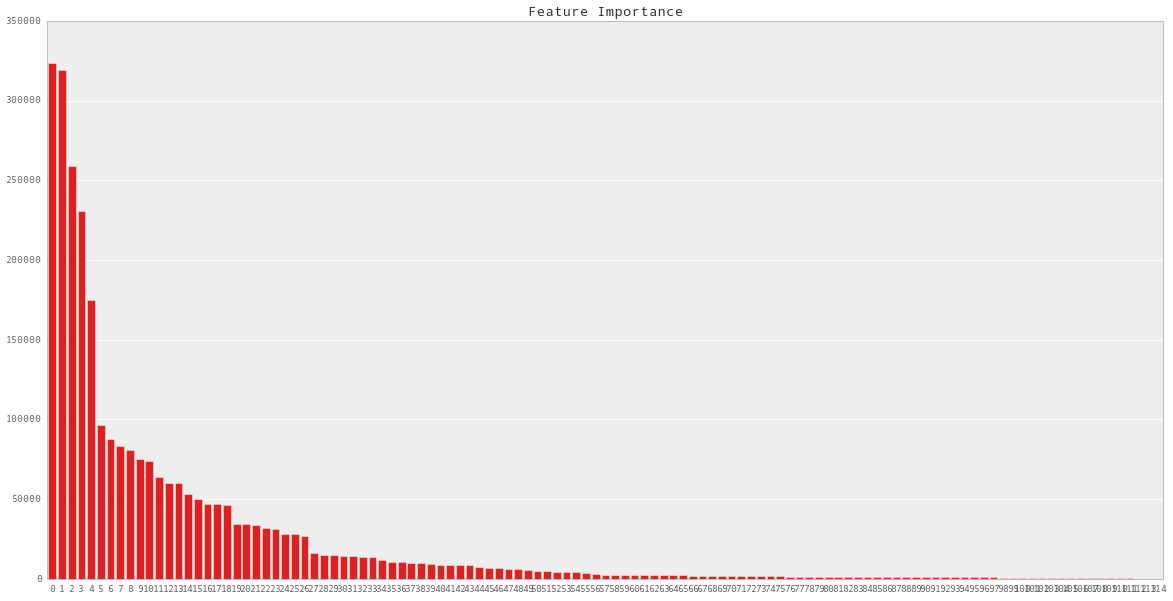

In [13]:
validation = False
feature_selection = None
algorithms = ['xgb']
algorithm = 'xgb'


if validation:
    number_of_folds = 1
    compute_optimal_alpha = True
    
    if compute_optimal_alpha:
        grid_space = [12, 13, 14, 15]
        alphas, scores, min_alpha, min_score = train_and_score(train, number_of_folds, grid_space=grid_space,
                                                               feature_selection=feature_selection, algorithm=algorithm, 
                                                               plot_importances=False)
        print('MIN_ALPHA =', min_alpha, 'MIN_RMSPE =', min_score)
        pl.figure(figsize=(15,10))
        pl.plot(alphas, scores, 'r.--')
        del grid_space, scores, alphas
    else:
        rmspe_cv, predicted_labels, test_labels = train_and_score(train, number_of_folds, algorithm=algorithm,
                                                                      feature_selection=feature_selection)
    
elif not validation:
    train_array, train_array_labels, test_array, feature_names = get_all_data(train, test, 
                                                                              feature_selection=feature_selection, 
                                                                              algorithm=algorithm)
    test_predicted_labels = fit_predict_model(train_array, train_array_labels, test_array, algorithm=algorithm,
                                              feature_names=feature_names, plot_importances=True)
    
    test['Sales'] = test_predicted_labels
    del train_array, train_array_labels, test_array, feature_names, test_predicted_labels
    test.ix[test.Open == 0, 'Sales'] = 0
    filename = 'prediction_' + algorithm + '.csv'
    test.Id = test.Id.astype('int')
    test[['Id', 'Sales']].to_csv(filename, index=False)
    print('\nResult was written to', filename)
    del test['Sales']
    
gc.collect()